<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

#### Иморт библиотек:

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
RANDOM_STATE = 12345
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

#### Импорт датасета

In [2]:
try:
    data = pd.read_csv('taxi.csv')
    print('датасет загружен локально')
except:
    data = pd.read_csv('/datasets/taxi.csv')
    print('датасет загружен с сервера')

датасет загружен локально


In [3]:
data[:1]

,datetime,num_orders
0,2018-03-01 00:00:00,9


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
data.duplicated().sum()

0

In [6]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y.%m.%d %H:%M:%S')
data = data.set_index('datetime', drop=True)

In [8]:
data[:1]

,num_orders
datetime,
2018-03-01,9


### ИТОГ:
Данные подготовлены

## Анализ

In [9]:
# Проверим датасет на упорядоченность данных
data = data.sort_index()
data.index.is_monotonic

True

<AxesSubplot: xlabel='datetime'>

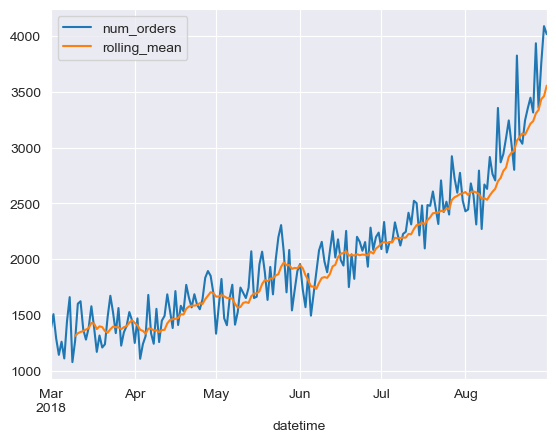

In [10]:
# посмотрим на ресемплированные данные по дням со скользящим средним
data_resample = data.resample('1D').sum()
data_resample['rolling_mean'] = data_resample.rolling(10).mean()
data_resample.plot()

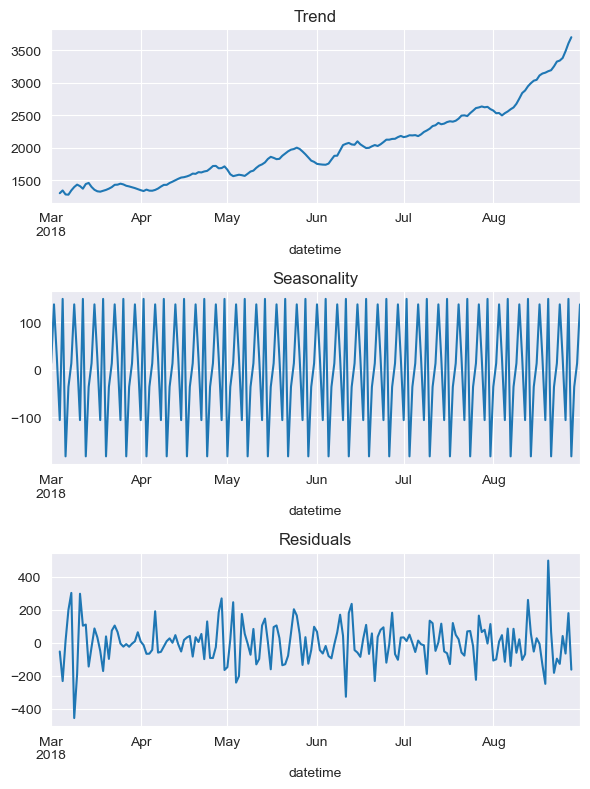

In [11]:
# Построим графики сезонности и тренда
data_resample = data.resample('1D').sum()

decomposed = seasonal_decompose(data_resample)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot: xlabel='datetime'>

<AxesSubplot: xlabel='datetime'>

<AxesSubplot: xlabel='datetime'>

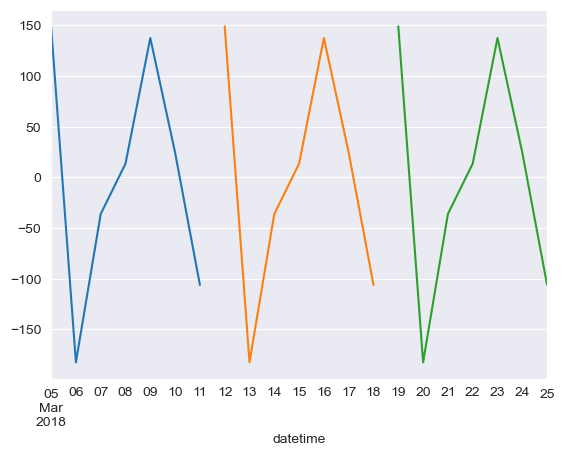

In [12]:
# Посмотрим сезонность в одном месяце по неделям
display(decomposed.seasonal['2018-03-05':'2018-03-11'].plot())
display(decomposed.seasonal['2018-03-12':'2018-03-18'].plot())
display(decomposed.seasonal['2018-03-19':'2018-03-25'].plot())

### ИТОГ:
Видим, что каждую неделю происходит то же самое - в понедельник и пятницу большое кол-во заказов,
а вот по вторникам заказов всегда минимум
Трендовый график показывает что в целом кол-во заказов растет


## Обучение

In [13]:
data.sort_index(inplace=True)
dt = data.resample('1H').sum()

def make_features(dt, max_lag, rolling_mean_size):
    dt['month'] = dt.index.month
    dt['day'] = dt.index.day
    dt['dayofweek'] = dt.index.dayofweek
    dt['hour'] = dt.index.hour

    for lag in range(1, max_lag + 1):
        dt['lag_{}'.format(lag)] = dt['num_orders'].shift(lag)
    dt['rolling_mean'] = dt['num_orders'].shift().rolling(rolling_mean_size).mean()

In [47]:
def search_model(model):
    best_rmse = 100
    for i in range (1, 10, 1):
            for j in range(1, 10, 1):
                make_features(dt, i, j)

                train, test = train_test_split(dt, shuffle=False, test_size=0.1)
                train = train.dropna()

                features_train = train.drop(['num_orders'], axis=1)
                target_train = train['num_orders']

                features_test = test.drop(['num_orders'], axis=1)
                target_test = test['num_orders']

                model.fit(features_train, target_train)
                probs_train = model.predict(features_train)
                probs_test = model.predict(features_test)

                rmse = mean_squared_error(probs_train,target_train, squared=False)
                if rmse < best_rmse:
                    best_rmse = rmse
            print(int(i/10 * 100 + 10),'%', sep='', end=' ')
    print()
    print(f'rmse обучающей выборки {i, j}:', best_rmse)
    print(f'rmse тестовой выборки {i, j}: ', mean_absolute_error(probs_test,target_test))
    return best_rmse, mean_absolute_error(probs_test,target_test)

In [48]:
line_rmse_train, line_rmse_test = search_model(LinearRegression())

20% 30% 40% 50% 60% 70% 80% 90% 100% 
rmse обучающей выборки (9, 9): 30.229270586580782
rmse тестовой выборки (9, 9):  40.59562980532319


In [49]:
cat_rmse_train, cat_rmse_test = search_model(CatBoostRegressor(verbose=False))

20% 30% 40% 50% 60% 70% 80% 90% 100% 
rmse обучающей выборки (9, 9): 12.460383494991099
rmse тестовой выборки (9, 9):  33.01994479087663


In [50]:
lgb_rmse_train, lgm_rmse_test = search_model(lgb.LGBMRegressor())

20% 30% 40% 50% 60% 70% 80% 90% 100% 
rmse обучающей выборки (9, 9): 13.90081736553534
rmse тестовой выборки (9, 9):  31.664344113313643


## ВАЖНЫЙ ВОПРОС ПРОВЕРЯЮЩЕМУ):
Я перебрал 2 гиперпараметры - ```max lag``` и ```rolling mean size``` - каждый раз у меня лучший результат при максимальных значениях этих параметров.
У меня есть сомнение в правильности подбора. Можно какую то доп информацию? какие ограничения при подборе этих параметров?

## Выводы

In [54]:
# создадим таблицу с результатами
d = {
    'Model': ['LinearRegression', 'LightGBM', 'CatBoost'],
    'RMSE train': [line_rmse_train, lgb_rmse_train , cat_rmse_train],
    'RMSE test': [line_rmse_test, lgm_rmse_test, cat_rmse_test]}
result = pd.DataFrame(data=d)
result

,Model,RMSE train,RMSE test
0,LinearRegression,30.229271,40.595630
1,LightGBM,13.900817,31.664344
2,CatBoost,12.460383,33.019945


## Общий вывод:
Модели бустинга выдают хороший результат на данном датасмете, но при постоянном использовании
придется учитывать то, что такие модели плохо реагируют на тренды, но я так понимаю эта тема другого спринта)

Модель линейной регрессии справилась с задачей - результат менее 48.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48